In [3]:
import numpy as np
import quantum_stuff as qs
import matplotlib.pyplot as plt
from tqdm import tqdm
import scienceplots
import sklearn.linear_model as LM
from scipy.special import comb
import scipy.sparse as sp

plt.style.use(['science', 'no-latex'])

σx = qs.sigmax()
σy = qs.sigmay()
σz = qs.sigmaz()
σm = qs.sigmam()
σp = qs.sigmap()
I = np.eye(2)
tqo = [np.kron(i,j) for i in [σx,σy,σz] for j in [σx,σy,σz] if np.allclose(i,j)]

In [4]:
Nq = 5
δt = 1
Js = 1
Δ = .1
γ = .1

J = qs.random_coupling(Js, Nq)
h = Δ*Js
wo = 1000
train_size = 1000
test_size = 1000
dim = wo + train_size + test_size
X = qs.local_operators(σx, Nq)
Z = qs.local_operators(σz, Nq)

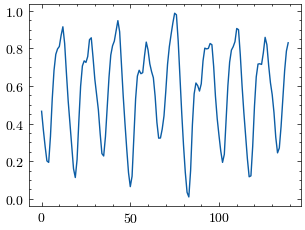

In [3]:
sk = np.load('Input_MG.npy')
plt.plot(sk[:140])

In [4]:
H1 = h*np.sum(X,0)
H0 = np.sum(qs.interaction(X, J) + h*Z,0)

In [14]:
c_ops = np.sqrt(γ)*qs.local_operators(σm, Nq)
H0 = sp.csc_matrix(H0)
H1 = sp.csc_matrix(H1)
c_ops = [sp.csc_matrix(c) for c in c_ops]
ridge, x_train , ρf = CD_forecast_training(sk, H1, H0, c_ops, δt, wo, train_size, ρ = None)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [01:57<00:00, 16.95it/s]


(2000, 32, 32)


In [15]:
y_pred = qs.CD_forecast_test(ridge, sk, ρf, H1, H0, c_ops, δt, wo, train_size)

100%|██████████| 149/149 [00:09<00:00, 15.91it/s]


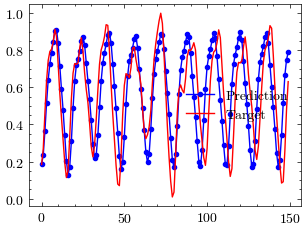

In [16]:
plt.plot(range(150), y_pred[:150], label = 'Prediction', color = 'blue', marker = '.')
plt.plot(range(150), sk[wo+train_size:wo+train_size+150], label = 'Target', color = 'red')
plt.legend(loc = 'center right')

Consistency Measure

In [25]:
ρ = qs.zero(dm = True, N = Nq)
cooldown = 1000
c_ops = np.sqrt(γ)*qs.local_operators(σm, Nq)
c_ops = [sp.csc_matrix(c) for c in c_ops]
H1, H0 = sp.csc_matrix(H1), sp.csc_matrix(H0)

ridge, x1, ρt1 = qs.CD_forecast_training(sk, H1, H0, c_ops, δt, wo, train_size, ρ = None)
ρ = qs.cooldown(ρt1, H0, c_ops, 1000, δt)
ridge, x2, ρt2 = qs.CD_forecast_training(sk, H1, H0, c_ops, δt, wo, train_size, ρ = ρ)





  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [02:04<00:00, 16.10it/s]


In [ ]:
x1 = np.real(np.hstack((qs.local_measurements(ρt1).reshape(train_size, 3*Nq), qs.two_qubits_measurements(ρt1, tqo))))
x2 = np.real(np.hstack((qs.local_measurements(ρt2).reshape(train_size, 3*Nq), qs.two_qubits_measurements(ρt2, tqo))))
consistency = qs.consistency(x1, x2)

ValueError: cannot reshape array of size 15 into shape (1000,15)

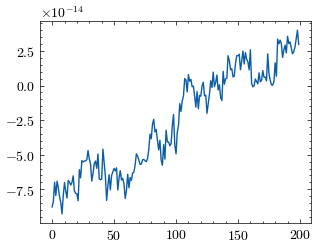

In [364]:
plt.plot(range(200), x1.T[0][0:200] - x2.T[0][0:200])

In [370]:
consistency = np.abs(x1**2 - x1*x2)

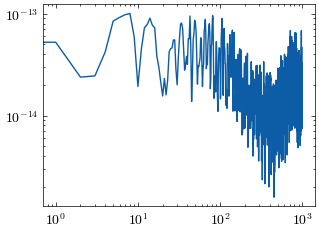

In [371]:
plt.loglog(np.median(consistency[:],1))

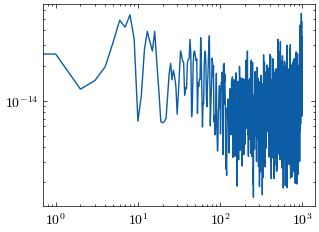

In [366]:
plt.loglog(np.median(consistency[:],1))

Memory Test

In [141]:
ρ_res = [qs.random_qubit(Nq, dm = True) for i in range(2)]

In [142]:
tstep = 1
ρt1 = np.zeros((wo + train_size, 4**Nq), dtype = complex)
ρt2 = np.zeros((wo + train_size, 4**Nq), dtype = complex)
for j in tqdm(range(2)):
    ρ = ρ_res[j]
    for i in range(wo + train_size):
        # superh = qs.Super_H(H0 + (sk[i] + 1)*H1)
        superh = qs.Super_H((sk[i] + 1)*H1)
        if j == 1:
            ρt1[i] = qs.Lindblad_Propagator(superh, superd, δt, ρ)
            ρ = ρt1[i]
        else:
            ρt2[i] = qs.Lindblad_Propagator(superh, superd, δt, ρ)
            ρ = ρt2[i]

100%|██████████| 2/2 [00:15<00:00,  7.97s/it]


In [147]:
dist = np.real(qs.distance(ρt1.reshape((wo + train_size, 2**Nq, 2**Nq)), ρt2.reshape((wo + train_size, 2**Nq, 2**Nq))))

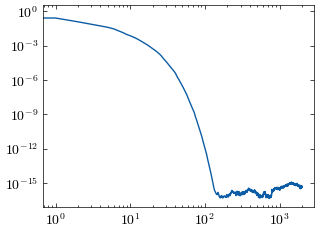

In [148]:
plt.loglog(dist)

Spectral Radius

In [ ]:
x = np.zeros((dim, int(3*Nq + 3*comb(Nq, 2))))

In [ ]:
ρ_wo = ρ[:wo]
ρ_train = ρ[wo:wo + train_size]
output = qs.collisions(ρ_wo, ρ_res[0], H1, δt, tstep)
ρ_res = qs.ptrace(output[-1], list(range(1, Nq)))
output_train = qs.collisions(ρ_train, ρ_res, H1, δt, tstep)
ρ_res_test = qs.ptrace(output_train[-1], list(range(1, Nq)))

In [ ]:
x = np.hstack((qs.local_measurements(output_train), qs.two_qubits_measurements(output_train, [xx, yy, zz]), np.ones((train_size, 1))))
alpha = np.logspace(-9,3,1000)
ridge = LM.RidgeCV(alphas = alpha)
y_target = sk[wo+1:wo+train_size+1]
ridge.fit((x), y_target)


RidgeCV(alphas=array([1.00000000e-09, 1.02804473e-09, 1.05687597e-09, 1.08651577e-09,
       1.11698682e-09, 1.14831241e-09, 1.18051653e-09, 1.21362380e-09,
       1.24765955e-09, 1.28264983e-09, 1.31862140e-09, 1.35560179e-09,
       1.39361927e-09, 1.43270295e-09, 1.47288272e-09, 1.51418933e-09,
       1.55665436e-09, 1.60031031e-09, 1.64519059e-09, 1.69132952e-09,
       1.73876240e-09, 1.78752553e-0...
       5.29326606e+02, 5.44171429e+02, 5.59432571e+02, 5.75121707e+02,
       5.91250841e+02, 6.07832313e+02, 6.24878807e+02, 6.42403366e+02,
       6.60419396e+02, 6.78940681e+02, 6.97981391e+02, 7.17556092e+02,
       7.37679760e+02, 7.58367791e+02, 7.79636013e+02, 8.01500696e+02,
       8.23978568e+02, 8.47086827e+02, 8.70843150e+02, 8.95265713e+02,
       9.20373200e+02, 9.46184819e+02, 9.72720319e+02, 1.00000000e+03]))

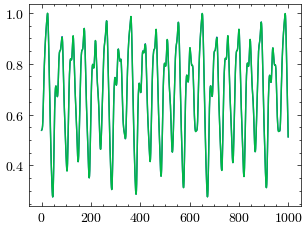

In [ ]:
plt.plot(range(train_size),sk[wo+1:wo+train_size+1], range(train_size), grid_search.predict(x))

In [ ]:
ρ_in = ρ[wo + train_size][np.newaxis]
ρ_res_test = qs.ptrace(output_train[-1], list(range(1, Nq)))
y_pred = np.zeros(test_size)
x_test = []
for i in range(200):
    output_test = qs.collisions(ρ_in, ρ_res_test, H1, δt, tstep)
    ρ_res_test = qs.ptrace(output_test[0], list(range(1,Nq)))
    x_test.append(np.hstack((qs.local_measurements(output_test), qs.two_qubits_measurements(output_test, [xx, yy, zz]), np.ones((1, 1)))))
    y_pred[i] = ridge.predict(x_test[i])
    if y_pred[i] < 0:
        y_pred[i] = 0
    ρ_in = qs.FNencoding(y_pred[np.newaxis, i], basis = 'z', dm = True)

C:\Users\marco\AppData\Local\Temp\ipykernel_13272\413901852.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\marco\AppData\Local\Temp\ipykernel_13272\413901852.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\marco\AppData\Local\Temp\ipykernel_13272\413901852.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\marco\AppData\Local\Temp\ipykernel_13272\413901852.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is d

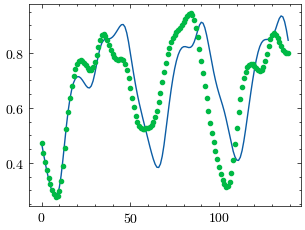

In [ ]:
plt.plot(range(test_size)[:140], sk[wo + train_size+1:][:140], range(test_size)[:140], y_pred[:140], '.')